In [1]:
import torch
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
!pip install pyro-ppl

In [3]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn

from pyro.infer import MCMC, NUTS, Predictive

/home/soumik/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Real Observations

t_obs = torch.linspace(0., 5., 50).unsqueeze(-1)          # 50 × 1
u_true = 0.5*t_obs**2 + t_obs
noise = 0.1
u_obs = u_true + noise * torch.randn_like(u_true)     # 50 X 1
u_obs = u_obs.squeeze()


# Collocation Points
t_f = torch.linspace(0., 5., 70).unsqueeze(-1).requires_grad_(True)

# initial condition point
t_ic = torch.tensor([[0.0]], requires_grad=True)

In [5]:
def compute_pde_residual(t,u):
    

SyntaxError: incomplete input (1882278642.py, line 2)

In [11]:
class BNN(PyroModule):
    def __init__(self, in_dim=1, out_dim=1, hid_dim=50, prior_scale=10.):
        super().__init__()

        self.activation = nn.Tanh()  
        self.layer1 = PyroModule[nn.Linear](in_dim, hid_dim)  # Input to hidden layer
        self.layer2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.layer3 = PyroModule[nn.Linear](hid_dim, out_dim)  # Hidden to output layer

        # Set layer parameters as random variables
        self.layer1.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, in_dim]).to_event(2))
        self.layer1.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer2.weight = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim, hid_dim]).to_event(2))
        self.layer2.bias = PyroSample(dist.Normal(0., prior_scale).expand([hid_dim]).to_event(1))
        self.layer3.weight = PyroSample(dist.Normal(0., prior_scale).expand([out_dim, hid_dim]).to_event(2))
        self.layer3.bias = PyroSample(dist.Normal(0., prior_scale).expand([out_dim]).to_event(1))

    
    def neural_net(self,t):
        h_1 = self.activation(self.layer1(t))
        h_2 = self.activation(self.layer2(h_1))
        return self.layer3(h_2).squeeze(-1)
    

    def forward(self,t_obs,u_obs = None,t_f = None,t_ic = None):
        #t_f = t_f.requires_grad_(True)
        # u_pred_obs = self.neural_net(t_obs)
        # u_ic = self.neural_net(t_ic)
        # u_f = self.neural_net(t_f)

        # du_dt = autograd.grad(u_f,t_f,grad_outputs=torch.ones_like(u_f),create_graph=True)[0].squeeze(-1)
        # res_pde =  du_dt - t_f.squeeze(-1)

        # res_ic = u_ic - 0.0
        

    # def forward(self, t_obs, u_obs=None):
    #     t = t_obs.reshape(-1, 1)
    #     h_1 = self.activation(self.layer1(t))
    #     h_2 = self.activation(self.layer2(h_1))
    #     u_pred_obs = self.layer3(h_2).squeeze()

        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))  # Infer the response noise
        u_pred_obs = self.neural_net(t_obs).squeeze(-1)
        with pyro.plate("data", t_obs.shape[0]):
            pyro.sample("obs", dist.Normal(u_pred_obs, sigma * sigma), obs=u_obs)

        # if u_obs is not None:
        #     with pyro.plate("data", t_obs.shape[0]):
        #         pyro.sample("obs", dist.Normal(u_pred_obs, sigma * sigma), obs=u_obs)

        if t_f is not None:
            t_f = t_f.requires_grad_(True)
            u_pred_f = self.neural_net(t_f).squeeze(-1)
            du_dt = autograd.grad(u_pred_f,t_f,grad_outputs=torch.ones_like(u_pred_f),create_graph=True)[0].squeeze(-1)
            res_pde =  du_dt - t_f.squeeze(-1)
            with pyro.plate("physics",t_f.shape[0]):
                pyro.sample("pde", dist.Normal(res_pde, sigma * sigma), obs=torch.zeros_like(res_pde))

        if t_ic is not None:
            u_pred_ic = self.neural_net(t_ic).squeeze(-1)
            res_ic = u_pred_ic - 0.0
            with pyro.plate("initial",t_ic.shape[0]):
                pyro.sample("ic", dist.Normal(res_ic, sigma * sigma), obs=torch.zeros_like(res_ic))




    #     # Data Likelihood
        # with pyro.plate("data", t_obs.shape[0]):
        #     pyro.sample("obs", dist.Normal(u_pred_obs, sigma * sigma), obs=u_obs)
        #       #obs = pyro.sample("obs", dist.Normal(u_pred_obs, sigma * sigma), obs=u_obs)

        # IC Likelihood
        # with pyro.plate("initial",t_ic.shape[0]):
        #     pyro.sample("ic", dist.Normal(res_ic, sigma * sigma), obs=torch.zeros_like(res_ic))

        # PDE Likelihood
        # with pyro.plate("physics",t_f.shape[0]):
        #     pyro.sample("pde", dist.Normal(res_pde, sigma * sigma), obs=torch.zeros_like(res_pde))


        #return u_pred_f if t_f is not None else u_pred_obs

        return u_pred_obs

In [7]:
model = BNN()

pyro.set_rng_seed(42)

nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=50, num_chains=1)

with torch.enable_grad():
    mcmc.run(t_obs, u_obs, t_f, t_ic)



#mcmc.run(t_obs,u_obs,t_f, t_ic)

posterior_samples = mcmc.get_samples()

Sample: 100%|██████████| 150/150 [06:26,  2.58s/it, step size=1.17e-03, acc. prob=0.562]


In [13]:
from pyro.poutine import uncondition

predictive_model = uncondition(model)

predictive = Predictive(predictive_model, posterior_samples = posterior_samples, return_sites=["obs"])

t_test = torch.linspace(0.,5.,1000).unsqueeze(-1)

preds = predictive(t_test)




print(preds)



print(preds.keys())
for name, tensor in preds.items():
    print(f"{name!r} → shape {tuple(tensor.shape)}")

{'obs': tensor([[ 1.5900,  1.1373,  1.4099,  ..., 17.7493, 16.3817, 16.0596],
        [ 1.9901,  1.1393,  1.2827,  ..., 16.7583, 16.8440, 15.7751],
        [ 1.4562,  1.2701,  1.5701,  ..., 16.9064, 17.3352, 17.6492],
        ...,
        [ 1.9648,  0.7844,  1.3893,  ..., 15.8757, 17.2082, 15.2476],
        [ 1.7783,  0.5416,  1.4610,  ..., 17.0935, 15.4141, 16.5420],
        [ 1.3090,  0.2539,  0.7091,  ..., 17.2749, 15.4221, 17.3706]])}
dict_keys(['obs'])
'obs' → shape (100, 1000)


In [9]:
# preds["obs"] should be [num_samples, N_test]
y_samples = preds["obs"]
print("y_samples.shape =", y_samples.shape)  
# e.g. expect torch.Size([100, 1000])

# Check your test inputs too
print("t_test.shape    =", t_test.shape)    
# expect torch.Size([1000,1])

# If you convert to NumPy
t_test_np = t_test.cpu().numpy().ravel()
print("t_test_np.shape =", t_test_np.shape)  
# expect (1000,)

# Compute mean/std arrays
u_mean = y_samples.mean(0)       # shape [N_test]
u_std  = y_samples.std(0)        # shape [N_test]
print("u_mean.shape   =", u_mean.shape)   
print("u_std.shape    =", u_std.shape)    

# Finally, check your training observations
print("t_obs.shape    =", t_obs.shape)    # expect [50,1]
print("u_obs.shape    =", u_obs.shape)    # expect [50]

y_samples.shape = torch.Size([100, 1000])
t_test.shape    = torch.Size([1000, 1])
t_test_np.shape = (1000,)
u_mean.shape   = torch.Size([1000])
u_std.shape    = torch.Size([1000])
t_obs.shape    = torch.Size([50, 1])
u_obs.shape    = torch.Size([50])


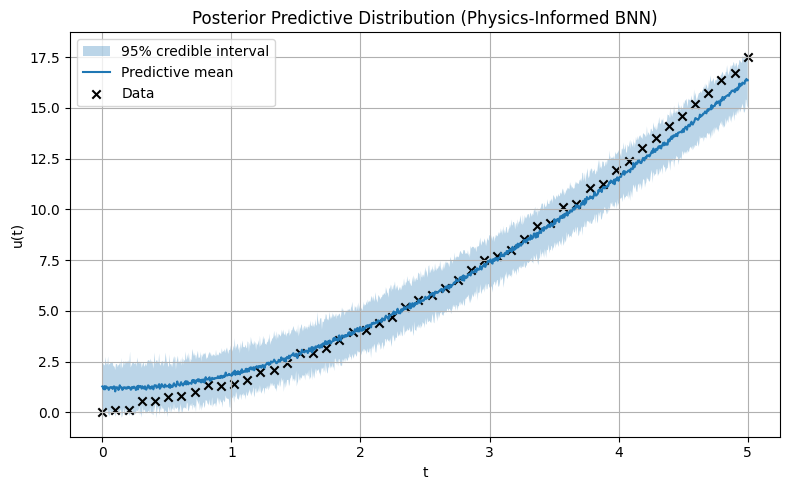

In [16]:

t_test_np = t_test.cpu().numpy().ravel()      # shape (1000,)
u_samples = preds["obs"].cpu().numpy()        # shape (num_samples, 1000)


mean_pred = u_samples.mean(axis=0)            # (1000,)
lower     = np.percentile(u_samples, 2.5, axis=0)
upper     = np.percentile(u_samples, 97.5, axis=0)


u_true = 0.5 * t_test_np**2 + t_test_np


t_obs_np = t_obs.squeeze(-1).cpu().numpy()    # (50,)
u_obs_np = u_obs.cpu().numpy()                # (50,)

# Plot
plt.figure(figsize=(8, 5))
plt.fill_between(t_test_np, lower, upper, alpha=0.3, label="95% credible interval")
plt.plot(t_test_np, mean_pred,label="Predictive mean")
plt.scatter(t_obs_np, u_obs_np,   marker='x', color='k', label="Data")
plt.xlabel("t")
plt.ylabel("u(t)")
plt.title("Posterior Predictive Distribution (Physics‑Informed BNN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()